### **Setup enviroment**

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras

import os
import pathlib
import time
from datetime import datetime
import shutil
from matplotlib import pyplot as plt
from IPython import display

In [ ]:
!pip install tqdm
from tqdm.auto import tqdm

Root folders declarations for easy change of enviroment

In [2]:
# Root directories
LOCAL_ROOT_DIR = '/content'
# LOCAL_ROOT_DIR = 'E:/TRAINING_OUTPUT_DIR_6'
DRIVE_ROOT_DIR = LOCAL_ROOT_DIR + '/drive'

In [3]:
from google.colab import drive
drive.mount(DRIVE_ROOT_DIR)

Mounted at /content/drive


Global variabes declarations

In [ ]:
# Global variables
#google drive directories
DRIVE_GENERATED_IMAGES_DIR = DRIVE_ROOT_DIR + '/MyDrive/pix2pix/vocalfolds/train_generated_images'
os.makedirs(DRIVE_GENERATED_IMAGES_DIR, exist_ok=True)
DRIVE_TEST_GENERATED_IMAGES_DIR = DRIVE_ROOT_DIR + '/MyDrive/pix2pix/vocalfolds/test_generated_images'
os.makedirs(DRIVE_TEST_GENERATED_IMAGES_DIR, exist_ok=True)

DRIVE_MODEL_OUTPUT_IMAGES_DIR = DRIVE_ROOT_DIR + '/MyDrive/pix2pix/vocalfolds/model_output_images'
os.makedirs(DRIVE_MODEL_OUTPUT_IMAGES_DIR, exist_ok=True)

LOG_DIR = DRIVE_ROOT_DIR + '/MyDrive/pix2pix/vocalfolds/logs'
os.makedirs(LOG_DIR, exist_ok=True)

MODEL_DIR = DRIVE_ROOT_DIR + '/MyDrive/pix2pix/vocalfolds/models'
os.makedirs(MODEL_DIR, exist_ok=True)

CHECKPOINTS_DIR = DRIVE_ROOT_DIR + '/MyDrive/pix2pix/vocalfolds/checkpoints'
os.makedirs(CHECKPOINTS_DIR, exist_ok=True)

PLOTS_DIR= DRIVE_ROOT_DIR + '/MyDrive/pix2pix/vocalfolds/plots'
os.makedirs(PLOTS_DIR, exist_ok=True)

# colab directories
LOCAL_DATA_DIR = LOCAL_ROOT_DIR + '/datasets'
PREPROCESSED_IMAGES_DIR = LOCAL_DATA_DIR + '/preprocessed'
TEST_SPLIT_FACTOR = 0.2 # 80% training and 20% test
TEST_SPLIT_DIR = PREPROCESSED_IMAGES_DIR + '/test'
TRAIN_SPLIT_DIR = PREPROCESSED_IMAGES_DIR + '/train'

LOCAL_AUGMENTED_DATASET_OUTPUT_DIR = LOCAL_DATA_DIR + '/augmented'
# os.makedirs(LOCAL_AUGMENTED_DATASET_OUTPUT_DIR, exist_ok=True)

# The training set consist of 351 images 
BUFFER_SIZE = 351
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 1
DATE_TIME_RUN = datetime.now().strftime("%Y%m%d-%H%M%S")

METRICS_FREQ = 50
METRICS_START_EPOCH = 1  # initial epoch to start monitor metrics
SAVE_PLOT_TRAIN_INTERVAL = 25

# Each image is 256x256 in size
IMG_WIDTH = 256
IMG_HEIGHT = 256
COLOR_CHANNELS = 3

SAVE_IMAGES_START = 50 # initial epoch to start save images
SAVE_IMAGES_INTERVAL = 25
EPOCHS = 2000
D_LEARNING_RATE = 2e-4
G_LEARNING_RATE = 2e-4
SAVE_EPOCH_START = 150 # initial epoch to start save checkpoints
SAVE_EPOCH_FREQ = 25

# #Reproducible results
SEED = 999
tf.random.set_seed(SEED)

# suffle images on loading from folders
SHUFFLE_ON_LOAD_IMAGES = True
LOAD_IMAGES_SHUFFLE_RANDOM_SEED = SEED # for reproducible files list order

Download and extract dataset images

In [ ]:
import os
import gdown
from zipfile import ZipFile
import tarfile

# Uncomment if you whant delete previous dataset dir
!rm -rf {LOCAL_DATA_DIR}

if not os.path.isdir(LOCAL_DATA_DIR):
    os.makedirs(LOCAL_DATA_DIR, exist_ok=True)

#     url = 'https://datasets.simula.no/kvasir-instrument/kvasir-instrument.tar.gz'
    # output = DRIVE_ROOT_DIR + '/MyDrive/pix2pix/VocalFolds.zip'
    # output = DRIVE_ROOT_DIR + '/MyDrive/pix2pix/111111.zip'
    output = DRIVE_ROOT_DIR + '/MyDrive/pix2pix/222222.zip'
#     gdown.download(url, output, quiet=False)
    # output = 'D:\Tesis Claudia\DataSets\VocalFoldsIntubationMasks\VocalFolds.zip'
   
    if output.endswith('tar.gz'):
        tar = tarfile.open(output, "r:gz")
        tar.extractall(LOCAL_DATA_DIR + '/VocalFolds')

        tar.close()
    elif output.endswith('.zip'):
        with ZipFile(output, "r") as zipobj:
            zipobj.extractall(LOCAL_DATA_DIR + '/VocalFolds')    

In [ ]:
files = os.listdir(LOCAL_DATA_DIR + '/VocalFolds/seq2/imagen')
sample_image = tf.io.read_file(LOCAL_DATA_DIR + '/VocalFolds/seq2/imagen/' + files[0])
sample_image = tf.io.decode_jpeg(sample_image)
print(sample_image.shape)

(512, 512, 3)


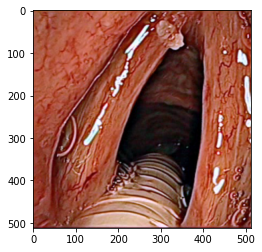

In [ ]:
plt.figure()
plt.imshow(sample_image)

In [ ]:
files = os.listdir(LOCAL_DATA_DIR + '/VocalFolds/seq2/mascara')
sample_mask = tf.io.read_file(LOCAL_DATA_DIR + '/VocalFolds/seq2/mascara/' + files[0])
sample_mask = tf.io.decode_jpeg(sample_mask)
print(sample_mask.shape)

(512, 512, 4)


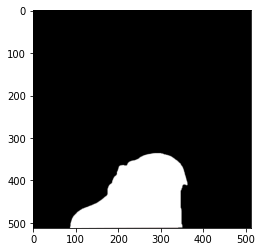

In [ ]:
plt.figure()
plt.imshow(sample_mask)

# Preprocess images

In [ ]:
def load_image_file(image_filename):    
    """  Load image file from file, decode and image """
    image = tf.io.read_file(image_filename)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32)
    
    return image

In [ ]:
def resize_image(image, width=IMG_WIDTH, height=IMG_HEIGHT):
    """ Resize image to specific size """
    image = tf.image.resize(image, 
                            [height, width],
                            method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return image

In [ ]:
# def resize_train_image(image):
#     if ((image.shape[1] != IMG_WIDTH) or (image.shape[2] != IMG_HEIGHT)):
#         image = resize_image(image, IMG_WIDTH, IMG_HEIGHT)
    
#     return image

In [ ]:
import os

def search_orphan_files(images_files_list, masks_files_list ,delete=False):
    """ Search and discard unpaired images and masks files """
    images_files = []
    mask_files = []
    orphan_files_to_delete = []
    
    # store images filenames
    for file in images_files_list:
        _, tail = os.path.split(file)
        images_files.append(tail)    
    
    # store masks filenames
    for file in masks_files_list:
        _, tail = os.path.split(file)
        mask_files.append(tail)  

    # get differences between both 
    diff = list(set(images_files) - set(mask_files)) + list(set(mask_files) - set(images_files))

    # build list of deletable unpaired orphan images
    for filename in diff:
        for file_abs_path in images_files_list:
            _, end = os.path.split(file_abs_path)
            if filename == end:
                orphan_files_to_delete.append(file_abs_path)
    # build list of deletable unpaired orphan masks
    for filename in diff:
        for file_abs_path in masks_files_list:
            _, end = os.path.split(file_abs_path)
            if filename == end:
                orphan_files_to_delete.append(file_abs_path)
    
    orphan_files = len(orphan_files_to_delete)
    # if there are deletable orphan files notify and delete them
    if orphan_files > 0:
        print(f'Orphans files found !!! ')
        if delete:
            print('Orphans files will be deleted...')
            for del_file in orphan_files_to_delete:
                if os.path.exists(del_file):
                    # delete file
                    os.remove(del_file)
                    try:
                        # delete image filename from list
                        images_files_list.remove(del_file)
                    except:
                        continue
                    
                    try:
                        # delete mask filename from list
                        masks_files_list.remove(del_file)
                    except:
                        continue
                else:
                    print(f'File {del_file} does not exists')
                    orphan_files = orphan_files - 1
            print(f'¨{orphan_files} file(s) were deleted')
        else:
            print(f'Consider delete following {orphan_files} files:')
            for file in orphan_files_to_delete:
                print(file)
            print(f'Total: {orphan_files} orphans files')
    else:
        print('No orphans (unpaired) files were found. Everything it`s ok')
    
    # return paired images and masks filename lists
    return images_files_list, masks_files_list


Preprocess datset folder (discard unpaired orphans, resize, join paired images, rename repeated, dataset split and save to correspondent sub folder)

In [ ]:
from keras.preprocessing.image import array_to_img
import os
import random

DIR = LOCAL_DATA_DIR + '/VocalFolds'

# check if previous preprocessing was done
if (os.path.isdir(PREPROCESSED_IMAGES_DIR) and len(os.listdir(PREPROCESSED_IMAGES_DIR)) > 0):
    print('Seems like a previous preprocessing was done, ignoring dataset preprocessing...')
else:
    # IMAGES
    images_files_list = []
    for directory in os.listdir(DIR):
        if directory.startswith('seq'):
            # set current dir
            curr_dir = DIR + '/' + directory  + '/imagen'
            # get files in current dir
            tmp  = sorted(filter(lambda x: x.endswith(('.jpg', '.jpeg', '.png')), 
                                              os.listdir(curr_dir)))
            # fill images list with files in current dir
            for file in tmp:
                curr_file = curr_dir + '/' + file
                images_files_list.append(curr_file)

    # MASKS
    masks_files_list = []
    for directory in os.listdir(DIR):
        if directory.startswith('seq'):
            # set current dir
            curr_dir = DIR + '/' + directory  + '/mascara'
            # get files in current dir
            tmp  = sorted(filter(lambda x: x.endswith(('.jpg', '.jpeg', '.png')), 
                                              os.listdir(curr_dir)))
            # fill images list with files in current dir
            for file in tmp:
                curr_file = curr_dir + '/' + file
                masks_files_list.append(curr_file)

    print(f'Images files: {len(images_files_list)}')
    print(f'Masks files: {len(masks_files_list)}')
    print(f'Total files: {len(images_files_list) + len(masks_files_list)}') 
    print(f'Difference images - masks: {len(images_files_list) - len(masks_files_list)}')
    print('--------------------------------------------')

    # preprocess orphan files in folders and in files lists
    images_files_list, masks_files_list = search_orphan_files(images_files_list, masks_files_list, True)

    # shuffle files lists if needed
    if SHUFFLE_ON_LOAD_IMAGES:
        # zip both lists in one for make paired random order
        zipped_files_lists = list(zip(images_files_list, masks_files_list))
        # ransomize files list order
        random.Random(LOAD_IMAGES_SHUFFLE_RANDOM_SEED).shuffle(zipped_files_lists)
        # unzip lists
        images_files_list, masks_files_list = zip(*zipped_files_lists)

    total_images_count = len(images_files_list)
    # set count of images to store on each dataset (test and training)
    test_split_count = total_images_count * TEST_SPLIT_FACTOR
    train_split_count = total_images_count - test_split_count
    current = 0
    output_dir = TRAIN_SPLIT_DIR
    for image_file_name in images_files_list:
        current = current + 1

        if current <= test_split_count:
            output_dir = TEST_SPLIT_DIR
        else: 
            output_dir = TRAIN_SPLIT_DIR
        # find corresponding mask in the mask list
        idx = images_files_list.index(image_file_name)
        mask_file_name = masks_files_list[idx]
        # load and convert both to jpg
        mask = load_image_file(image_file_name)
        image = load_image_file(mask_file_name)        
        # resize both to global configured image
        image = resize_image(image, width=IMG_WIDTH, height=IMG_HEIGHT)
        mask = resize_image(mask, width=IMG_WIDTH, height=IMG_HEIGHT)
        # join both image and mask 
        joined = np.concatenate((mask, image), axis = 1) # original
        # save joined image to preprocessed folder    
        _, file = os.path.split(image_file_name)
        output_file_name = output_dir + '/' + file
        os.makedirs(output_dir, exist_ok=True)
        output = array_to_img(joined)
        number = 0
        # rename current image filename if there are another with same name
        if os.path.isfile(output_file_name):
            number = number + 1
            while os.path.isfile(output_file_name):
                filepath, filename = os.path.split(output_file_name)
                split_filename, file_ext = os.path.splitext(filename)
                tmp_flnm = split_filename + '_' + str(number) + file_ext
                output_file_name = os.path.join(filepath + '/' + tmp_flnm)
            print('Renamed file: '+ output_file_name)
        # save preprocessed image to disk
        output.save(output_file_name)

Renamed file: /content/datasets/preprocessed/train/0035_l_1.png
Renamed file: /content/datasets/preprocessed/train/0033_l_1.png
Renamed file: /content/datasets/preprocessed/train/0023_l_1.png


In [ ]:
def load(image_file):
    # Read and decode an image file to a uint8 tensor
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)

    # Split each image tensor into two tensors:
    # - one with a real vocalfold image
    # - one with an segmentation mask image 
    w = tf.shape(image)[1]
    w = w // 2
    input_image = image[:, w:, :]
    real_image = image[:, :w, :]

    # Convert both images to float32 tensors
    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)

#     return input_image, real_image
    return real_image, input_image

test load() method and plot results

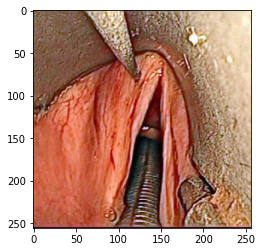

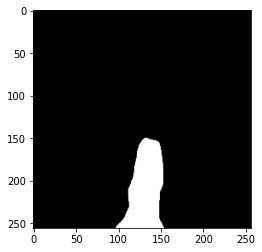

In [ ]:
files = os.listdir(TEST_SPLIT_DIR)

inp, re = load(TEST_SPLIT_DIR + '/' + files[0])
# Casting to int for matplotlib to display the images
plt.figure()
plt.imshow(inp / 255.0)
plt.figure()
plt.imshow(re / 255.0)

# Utils


Standalone methods to calculate Dice coefficient and AUC

In [ ]:
import sys
import numpy as np
from keras import backend as K


def dice_coef(y_true, y_pred, smooth=1):
    # denormalize input images 
    y_pred = y_pred * 0.5 + 0.5
    y_true = y_true * 0.5 + 0.5
    # flaten images
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def auc(y_true, y_pred, num_thresholds=200):
    y_pred = y_pred * 0.5 + 0.5
    y_true = y_true * 0.5 + 0.5
    m = tf.keras.metrics.AUC(num_thresholds=num_thresholds)
    m.update_state(y_true, y_pred)
    return m.result().numpy()

# Dataugmentation and Dataset building

As described in pix2pix paper is needed apply random jittering and mirroring to preprocess the training set.

Define several functions that:

* Resize each 256 x 256 image to a larger height and width—286 x 286.
* Randomly crop it back to 256 x 256.
* Randomly flip the image horizontally i.e. left to right (random mirroring).
* Normalize the images to the [-1, 1] range.

In [ ]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

In [ ]:
def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1]

In [ ]:
# Normalizing the images to [-1, 1]
def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

In [ ]:
@tf.function()
def random_jitter(input_image, real_image):
  # Resizing to 286x286
  input_image, real_image = resize(input_image, real_image, 286, 286)

  # Random cropping back to 256x256
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # Random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

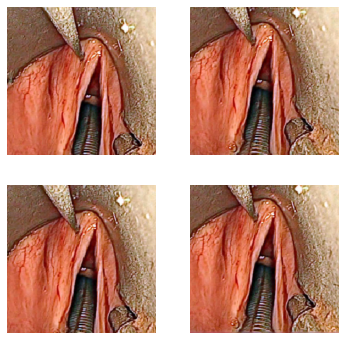

In [ ]:
# inspect some of preprocessed results
plt.figure(figsize=(6, 6))
for i in range(4):
  rj_inp, rj_re = random_jitter(inp, re)
  plt.subplot(2, 2, i + 1)
  plt.imshow(rj_inp / 255.0)
  plt.axis('off')
plt.show()

Having checked that the loading and preprocessing works, let's define some helper functions that load and preprocess the training and test sets

In [ ]:
def load_image_train(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = random_jitter(input_image, real_image)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

In [ ]:
def load_image_test(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = resize(input_image, real_image, 
                                     IMG_HEIGHT, IMG_WIDTH)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

**Build an input pipe with tf.data**

In [ ]:
train_dataset = tf.data.Dataset.list_files(TRAIN_SPLIT_DIR + '/*.png')
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [ ]:
test_dataset = tf.data.Dataset.list_files(TEST_SPLIT_DIR + '/*.png')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

# Build generator

Generator is a modified U-Net. A U-Net consists of an encoder (downsampler) and decoder (upsampler). (find more about it in the Image segmentation tutorial and on the U-Net project website.)

* Each block in the encoder is: Convolution -> Batch normalization -> Leaky ReLU
* Each block in the decoder is: Transposed convolution -> Batch normalization -> Dropout (applied to the first 3 blocks) -> ReLU

There are skip connections between the encoder and decoder (as in the U-Net).

**Define the downsampler (encoder)**

In [ ]:
OUTPUT_CHANNELS = 3

In [ ]:
def downsample(filters, size, apply_batchnorm=True):
  """
  Each block in the encoder is: 
      Convolution -> Batch normalization -> Leaky ReLU
  """
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [ ]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)

(1, 128, 128, 3)


**Define the upsampler (decoder)**

In [ ]:
def upsample(filters, size, apply_dropout=False):
  """
  Each block in the decoder is: 
      Transposed convolution -> Batch normalization -> 
      Dropout (applied to the first 3 blocks) -> ReLU
  """
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [ ]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 256, 256, 3)


In [ ]:
# generador con el downsampler y el upsampler

**Generator definition with the downsampler and the upsampler**

In [ ]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[IMG_WIDTH, IMG_HEIGHT, COLOR_CHANNELS])
  # downsample stack
  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]
  # upsample stack
  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

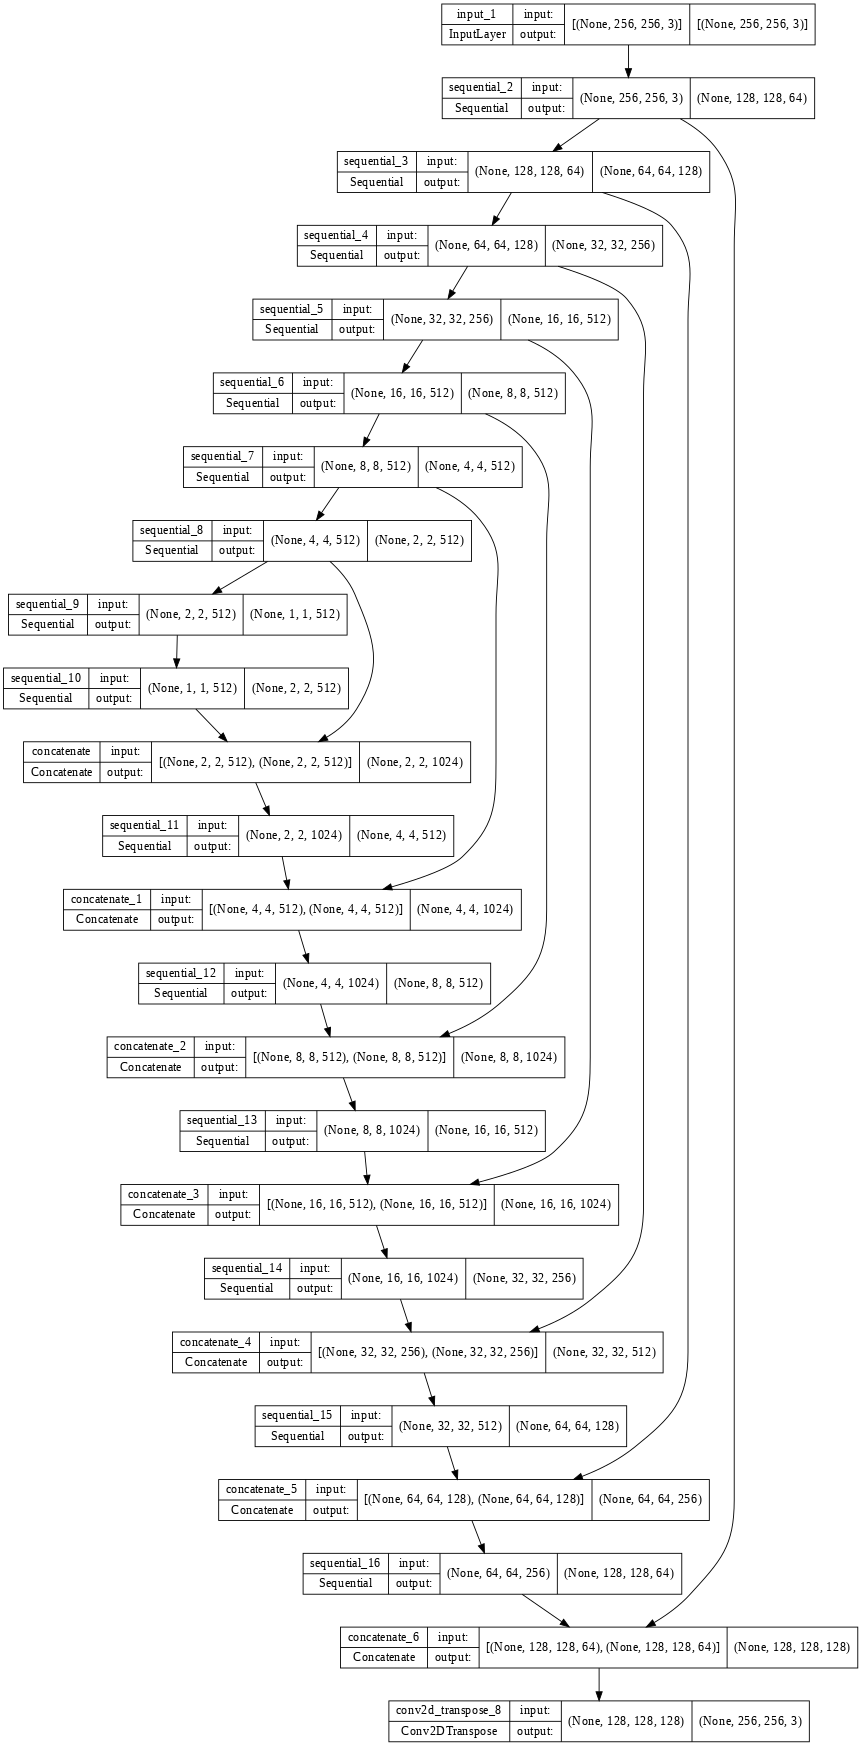

In [ ]:
# show and save generator architecture
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64, 
                          to_file=MODEL_DIR + '/generator_model.png')

**Test the generator output**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


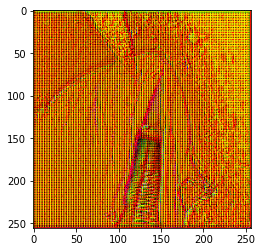

In [ ]:
gen_output = generator(inp[tf.newaxis, ...], training=False)
plt.imshow(gen_output[0, ...])

## **Generator loss definition**

GANs learn a loss that adapts to the data, while cGANs learn a structured loss that penalizes a possible structure that differs from the network output and the target image, as described in the pix2pix paper.

The generator loss is a sigmoid cross-entropy loss of the generated images and an array of ones.
The pix2pix paper also mentions the L1 loss, which is a MAE (mean absolute error) between the generated image and the target image.
This allows the generated image to become structurally similar to the target image.
The formula to calculate the total generator loss is gan_loss + LAMBDA * l1_loss, where LAMBDA = 100. This value was decided by the authors of the paper.

In [ ]:
LAMBDA = 100

In [ ]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
  # Mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
  total_gen_loss = gan_loss + (LAMBDA * l1_loss)
  return total_gen_loss, gan_loss, l1_loss

# Build the discriminator

The pix2pix cGAN discriminator is a convolutional PatchGAN classifier—it tries to classify if each image patch is real or not real, as described in the pix2pix paper.

Each block in the discriminator is: 
* Convolution -> Batch normalization -> Leaky ReLU.
* The shape of the output after the last layer is (batch_size, 30, 30, 1).
* Each 30 x 30 image patch of the output classifies a 70 x 70 portion of the input image.
* The discriminator receives 2 inputs:
  * The input image and the target image, which it should classify as real.
  * The input image and the generated image (the output of the generator), which it should classify as fake.
Use tf.concat([inp, tar], axis=-1) to concatenate these 2 inputs together.

In [ ]:
# Discriminator definition
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[IMG_WIDTH, IMG_HEIGHT, COLOR_CHANNELS], name='input_image')
    tar = tf.keras.layers.Input(shape=[IMG_WIDTH, IMG_HEIGHT, COLOR_CHANNELS], name='target_image')

    x = tf.keras.layers.concatenate([inp, tar]) # (batch_size, 256, 256, channels*2)

    down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
    down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
    down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1, 
                                  kernel_initializer=initializer, 
                                  use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)

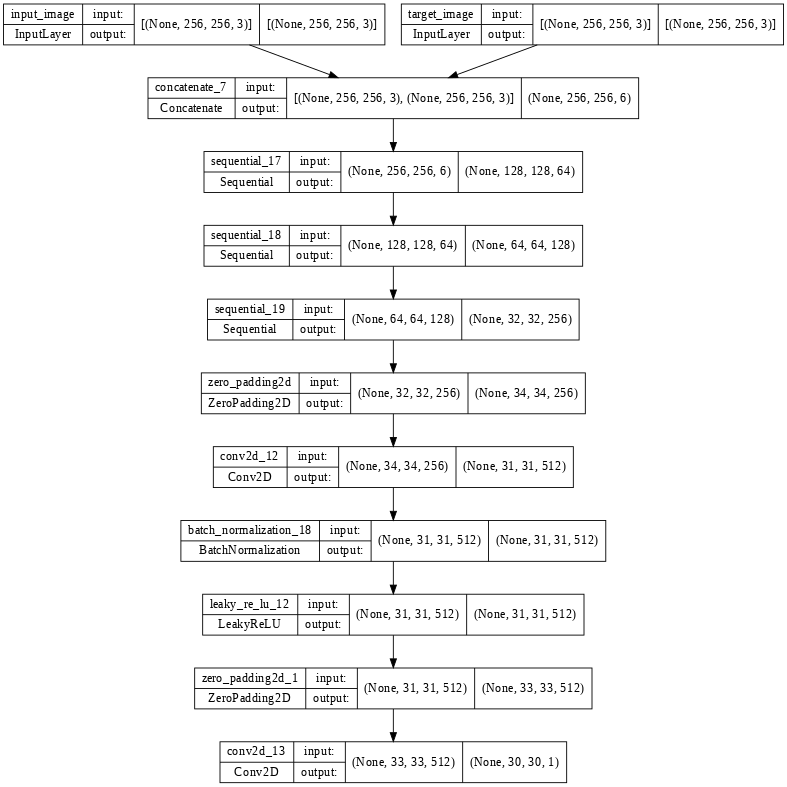

In [ ]:
# Show discriminator model architecture and save it to file
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64, 
                          to_file=MODEL_DIR + '/discriminator_model.png')

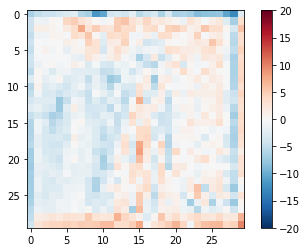

In [ ]:
# Test discriminator output
disc_out = discriminator([inp[tf.newaxis, ...], gen_output], training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

## **Define the discriminator loss**

* The discriminator_loss function takes 2 inputs: real images and generated images.
* real_loss is a sigmoid cross-entropy loss of the real images and an array of ones(since these are the real images).
* generated_loss is a sigmoid cross-entropy loss of the generated images and an array of zeros (since these are the fake images).
* The total_loss is the sum of real_loss and generated_loss.

In [ ]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

Write a function to plot some images during training.

Pass images from the test set to the generator.
The generator will then translate the input image into the output.
The last step is to plot the predictions

*Note: The training=True is intentional here since you want the batch statistics, while running the model on the test dataset. If you use training=False, you get the accumulated statistics learned from the training dataset (which you don't want).*

In [ ]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15, 15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # Getting the pixel values in the [0, 1] range to plot.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

# **Callbacks**

## **MetricsMonitor callback**

Save metric history to file

In [ ]:
def plot_metric_history(metric_hist, 
                        metric_legend_label=None,
                        y_label='Metric',
                        x_label='Epoch number',
                        plot_title='Metric title', 
                        x_labels_list=None, filename='./plot_metric.png',
                        grid=True,
                        show=False):  
    # plot loss
    pyplot.subplot(1, 1, 1)
    pyplot.ylabel(y_label)
    pyplot.xlabel(x_label)
    pyplot.title(plot_title)
    
    if x_labels_list and len(x_labels_list) <= 20:
        pyplot.xticks(x_labels_list, rotation='horizontal')      
    
    if metric_legend_label:
        pyplot.plot(x_labels_list, metric_hist, label=metric_legend_label)
        pyplot.legend()
    else:
        pyplot.plot(x_labels_list, metric_hist)
    
    pyplot.grid() if grid else None  
    # pyplot.tight_layout()
    # save plot to file
    pyplot.savefig(filename)
    pyplot.show() if show else None
    pyplot.close()

In [ ]:
def plot_metrics_from_csv_history(test_history_file=PLOTS_DIR+'/test_history.csv', 
                                  plot_filename='metric.png'):
    """
    Util method to plot metric history from .csv file
    """
    test_metrics_hist = []
    # last_epoch = 0
    if os.path.isfile(test_history_file):
        dataframe = pandas.read_csv(test_history_file)
        test_metrics_hist = dataframe.to_dict('records')

        epochs_list = [item_dict['epoch'] for item_dict in test_metrics_hist]
        # plot test dice_coef train dataset
        plot_metric_history(
            metric_hist=[round(item_dict['train_dice_coef'], 3) for item_dict in test_metrics_hist],
            y_label='Dice coefficient',
            x_label='Epoch number',
            plot_title='Train dataset Dice Coefficient metrics',
            x_labels_list=epochs_list,
            filename=PLOTS_DIR+'/train_ds_dice_coefficient.png')
        # plot test dice_coef test dataset
        plot_metric_history(
            metric_hist=[round(item_dict['test_dice_coef'], 3) for item_dict in test_metrics_hist],
            y_label='Dice coefficient',
            x_label='Epoch number',
            plot_title='Test dataset Dice Coefficient metrics',
            x_labels_list=epochs_list,
            filename=PLOTS_DIR+'/test_ds_dice_coefficient.png')

    else:
        print(f"File {test_history_file} does not exists")


In [ ]:
# # plot matrics from history.csv file
# plot_metrics_from_csv_history(PLOTS_DIR+'/test_history.csv')

Create a callback that periodically saves generated images

In [ ]:
class MetricsMonitor(tf.keras.callbacks.Callback):
    """
    This callback method calcs dice coefficient mean for training and test
    datasets (if given), saves generated masks for test dataset, plots
    results to image and prints resultant dice coefficient mean calculations
    """
    def __init__(self, test_dataset=None, train_dataset=None, 
                 metrics_freq=1, metrics_start_epoch=1):
        self.train_dataset = train_dataset # train_dataset
        self.test_dataset = test_dataset # test_dataset
        self.metrics_freq = metrics_freq
        self.metrics_start_epoch = metrics_start_epoch
        # metrics
        self.test_dice_coef_metric = keras.metrics.Mean(name="test_dice_coef")
        self.train_dice_coef_metric = keras.metrics.Mean(name="train_dice_coef")
        # keys
        self.keys = ['epoch', 'test_dice_coef', 'train_dice_coef']
        self.test_metrics_hist = []  
        self.test_history_file = PLOTS_DIR + '/test_history.csv'
    
    def load_test_history(self):
        """loads metrics from .csv file until current epoch number"""
        last_epoch = 0
        if os.path.isfile(self.test_history_file):
            dataframe = pandas.read_csv(self.test_history_file)
            self.test_metrics_hist = dataframe.to_dict('records')
            last_epoch = int(self.test_metrics_hist[len(self.test_metrics_hist) - 1]['epoch'])

        return last_epoch

    def on_train_begin(self, epoch, logs=None):
        # make backup and load existing train_history.csv file
        if os.path.isfile(self.test_history_file):
            date_time_str = datetime.now().strftime("%Y%m%d-%H%M%S")
            shutil.copy2(self.test_history_file,
                         self.test_history_file + f".{date_time_str}-E{self.load_test_history()}.bak.csv")
        else:
            # just make backup
            self.load_test_history()

    def on_epoch_begin(self, epoch, logs=None):
        # load history from csv file
        if epoch == 0:
            self.test_metrics_hist = [] 
        # else if last registered epoch is heigher than current epoch
        elif len(self.test_metrics_hist) > 0 and int(self.test_metrics_hist[len(self.test_metrics_hist) - 1]['epoch']) > epoch:
            # store heigher epoch index
            heigher_epoch_idx = len(self.test_metrics_hist) - 1
            # split array until  just before the heiger epoch index
            self.test_metrics_hist = self.test_metrics_hist[:heigher_epoch_idx]

    def on_epoch_end(self, epoch, logs=None):
        # reset metrics state
        self.test_dice_coef_metric.reset_state()
        self.train_dice_coef_metric.reset_state()

        if (epoch + 1) >= self.metrics_start_epoch and (epoch + 1) % self.metrics_freq == 0:    
            test_dice_coef = 0.0
            mean_test_dice_coef = 0.0
            train_dice_coef = 0.0
            mean_train_dice_coef = 0.0
            metrics_dict = {'epoch': epoch + 1,
                            'test_dice_coef': 0.0,
                            'train_dice_coef': 0.0,
                            }            
            test_generated_images = []

            #### Test ####
            if self.test_dataset:
                print("Calculating Dice Coefficient with test dataset...")
                for test_images in tqdm(self.test_dataset):
                    input_image, target = test_images
                    gen_output = self.model.generator(input_image, training=True)
                    

                    ###metrics###
                    test_dice_coef = self.model.calc_dice_coef(target, gen_output)
                    self.test_dice_coef_metric.update_state(test_dice_coef)
                    
                    # ### store generated and denormalized images for future save
                    horizontal = np.concatenate((input_image, target, gen_output), axis = 2)
                    normalized_images = horizontal[0] * 0.5 + 0.5
                    test_generated_images.append(normalized_images)
      
                # calc Dice coefficient mean for test dataset
                mean_test_dice_coef = self.test_dice_coef_metric.result()

                # write to tensorboard
                with test_file_writer.as_default():
                    tf.summary.scalar('test_dice_coef', mean_test_dice_coef, step=epoch)

                # Save test generated images...
                for i in range(len(test_generated_images)):
                    img = keras.preprocessing.image.array_to_img(test_generated_images[i])
                    img.save(DRIVE_TEST_GENERATED_IMAGES_DIR + '/test_gen_img_%03d_%d.png' % ((epoch + 1), i))
            
            #### training metrics ####
            if self.train_dataset:
                print(f"Calculating Dice Coefficient with training dataset...")
                for train_images in tqdm(self.train_dataset):                  
                    input_image, target = train_images
                    ### metrics ###                
                    gen_output = self.model.generator(input_image, training=True)
                    train_dice_coef = self.model.calc_dice_coef(target, gen_output)
                    self.train_dice_coef_metric.update_state(train_dice_coef)
                
                # calc mean Dice coefficient and add to historical lists
                mean_train_dice_coef = self.train_dice_coef_metric.result()

                # write to tensorboard
                with training_file_writer.as_default():  
                    tf.summary.scalar('train_dice_coef', mean_train_dice_coef, step=epoch)
          

            # store metrics dictionary to historical list            
            metrics_dict['epoch'] = epoch + 1
            metrics_dict['test_dice_coef'] = float(mean_test_dice_coef)
            metrics_dict['train_dice_coef'] = float(mean_train_dice_coef)
            self.test_metrics_hist.append(metrics_dict)

            # Build epochs numbers list for plotting
            epochs_list = [item_dict['epoch'] for item_dict in self.test_metrics_hist]
            
            if self.train_dataset:
                # plot test dice_coef train dataset
                plot_metric_history(
                    metric_hist=[round(item_dict['train_dice_coef'], 3) for item_dict in self.test_metrics_hist],
                    y_label='Dice coefficient',
                    x_label='Epoch number',
                    plot_title='Train dataset Dice Coefficient metrics',
                    x_labels_list=epochs_list,
                    filename=PLOTS_DIR+'/test_train_ds_dice_coefficient.png')
            
            if self.test_dataset:
                # plot test dice_coef test dataset
                plot_metric_history(
                    metric_hist=[round(item_dict['test_dice_coef'], 3) for item_dict in self.test_metrics_hist],
                    y_label='Dice coefficient',
                    x_label='Epoch number',
                    plot_title='Test dataset Dice Coefficient metrics',
                    x_labels_list=epochs_list,
                    filename=PLOTS_DIR+'/test_testds_dice_coefficient.png')
                    
            # remove tmp file
            if os.path.isfile(self.test_history_file+"_tmp"):
                os.remove(self.test_history_file+"_tmp")

            # write changes to csv file
            with open(self.test_history_file+"_tmp", 'w', 
                      encoding='utf8', newline='') as f:
                y = csv.DictWriter(f, fieldnames=self.keys)
                y.writeheader()
                y.writerows(self.test_metrics_hist)
                f.flush() # flushes the file internals buffers for clean close
            
            if os.path.isfile(self.test_history_file+"_tmp"):
                # remove regular file if exists
                if os.path.isfile(self.test_history_file):
                    os.remove(self.test_history_file)
                # rename tmp file to regular file
                if not os.path.isfile(self.test_history_file):
                    os.rename(self.test_history_file+"_tmp", self.test_history_file)
            
            print(f'train_dice_coef: {mean_train_dice_coef:.4f} - test_dice_coef: {mean_test_dice_coef:.4f}')

In [ ]:
# create a MetricsMonito callback instance
metrics_monitor_callback = MetricsMonitor(test_dataset=test_dataset,
                                          train_dataset=train_dataset,
                                          metrics_freq=METRICS_FREQ, metrics_start_epoch=METRICS_START_EPOCH)

## **GANMonitor callback**

In [ ]:
from matplotlib import pyplot
import os
import pandas
from keras.utils.io_utils import path_to_string
import collections
import csv

# Create a callback that periodically saves generated images
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, test_ds):  
        self.test_ds = test_ds
        self.keys = None
        self.train_history_file = PLOTS_DIR+'/train_history.csv'
        self.train_logs_hist = [] # [{'epoch': 1, 'd_loss': 1.18, 
                                  # 'g_loss': 1.98}, 'g_gan_loss': 1, 
                                  # 'g_l1_loss': 1.18, 'dice_coef': 1.98}, ...]        
    
    def load_train_history(self):
        loaded_epochs = 0
        if os.path.isfile(self.train_history_file):
            dataframe = pandas.read_csv(self.train_history_file)
            self.train_logs_hist = dataframe.to_dict('records')
            loaded_epochs = len(self.train_logs_hist)

        return loaded_epochs 

    def generate_images(self, test_input, tar):
        """
        Note: The training=True is intentional here since we want 
        the batch statistics, while running the model on the test dataset. 
        If we use training=False, we get the accumulated statistics learned 
        from the training dataset (which we don't want).
        """
        prediction = self.model.generator(test_input, training=True)
        horizontal = np.concatenate((test_input, tar, prediction), axis = 2)
        # display_list = [test_input[0], tar[0], prediction[0], horizontal[0]]

        # return display_list
        return prediction[0], horizontal[0]

    def plot_loss_history(self, d_hist, g_hist, g_gan_hist, g_l1_hist, 
                          x_labels_list=None, filename='./plot_train_loss.png'):
        # plot loss
        pyplot.subplot(1, 1, 1)
        pyplot.ylabel('Loss')
        pyplot.xlabel('Epoch number')
        pyplot.title('Training loss metrics')
        if x_labels_list and len(x_labels_list) <= 25:
            pyplot.xticks(range(len(x_labels_list)), x_labels_list, rotation='horizontal')
        pyplot.plot(d_hist, label='train d_loss')
        pyplot.plot(g_hist, label='train g_loss')
        pyplot.plot(g_l1_hist, label='train g_l1_loss')
        pyplot.plot(g_gan_hist, label='train g_gan_loss')
        pyplot.legend()
        # save plot to file
        pyplot.savefig(filename)
        pyplot.close()

    def plot_metrics_history(self, dice_coef_hist, x_labels_list=None, 
                             filename='./plot_train_metrics.png'):
        # plot loss
        pyplot.subplot(1, 1, 1)
        pyplot.ylabel('Dice Coefficient')
        pyplot.xlabel('Epoch number')
        pyplot.title('Training Dice Coefficient metrics')
        if x_labels_list and len(x_labels_list) <= 25:
            pyplot.xticks(range(len(x_labels_list)), x_labels_list, rotation='horizontal')
        pyplot.plot(dice_coef_hist, label='dice coefficient')
        pyplot.legend()
        # save plot to file
        pyplot.savefig(filename)
        pyplot.close()
    
    def on_train_begin(self, epoch, logs=None):        
        # load and make backup of existing train_history.csv file
        if os.path.isfile(self.train_history_file):
            date_time_str = datetime.now().strftime("%Y%m%d-%H%M%S")
            shutil.copy2(self.train_history_file, self.train_history_file+f".{date_time_str}-E{self.load_train_history()}.bak.csv")
        else: 
            # just make backup
            self.load_train_history()

    def on_epoch_begin(self, epoch, logs=None):
        # take passed epochs until current
        if epoch == 0:
            self.train_logs_hist = [] 
        elif len(self.train_logs_hist) > epoch:
            self.train_logs_hist = self.train_logs_hist[:epoch]

    def on_epoch_end(self, epoch, logs=None):
        # construct dict
        def handle_value(k):
            is_zero_dim_ndarray = isinstance(k, np.ndarray) and k.ndim == 0
            if isinstance(k, str):
                return k
            elif isinstance(k, collections.abc.Iterable) and not is_zero_dim_ndarray:
                return '"[%s]"' % (', '.join(map(str, k)))
            else:
                return k

        # set headers for csv file
        if self.keys is None:
            self.keys = ['epoch']
            self.keys += sorted(logs.keys())

        # store current training metrics
        row_dict = {'epoch': epoch + 1}
        row_dict.update((key, handle_value(logs[key])) for key in logs.keys()) 
        self.train_logs_hist.append(row_dict)


        if (epoch + 1) % SAVE_PLOT_TRAIN_INTERVAL == 0:   
            if len(self.train_logs_hist) <= 25: 
                epochs_list = [item_dict['epoch'] for item_dict in self.train_logs_hist]
            epochs_list = None

            # plot train loss results
            self.plot_loss_history(
                d_hist = [item_dict['d_loss'] for item_dict in self.train_logs_hist], 
                g_hist = [item_dict['g_loss'] for item_dict in self.train_logs_hist],
                g_gan_hist = [item_dict['g_gan_loss'] for item_dict in self.train_logs_hist], 
                g_l1_hist = [item_dict['g_l1_loss'] for item_dict in self.train_logs_hist], 
                x_labels_list=epochs_list,
                filename=PLOTS_DIR + '/plot_train_loss.png')
            # plot train metrics results
            self.plot_metrics_history(
                dice_coef_hist = [item_dict['dice_coef'] for item_dict in self.train_logs_hist], 
                x_labels_list=epochs_list, 
                filename=PLOTS_DIR + '/plot_train_metrics.png')
        
            # remove tmp file
            if os.path.isfile(self.train_history_file+"_tmp"):
                    os.remove(self.train_history_file+"_tmp")

            # write changes to file
            with open(self.train_history_file+"_tmp", 'w', 
                      encoding='utf8', newline='') as f:
                y = csv.DictWriter(f, fieldnames=self.keys)
                y.writeheader()
                y.writerows(self.train_logs_hist)
                f.flush() # flushes the file internal buffer for clean close
      
            if os.path.isfile(self.train_history_file+"_tmp"):
                # remove regular file if exists
                if os.path.isfile(self.train_history_file):
                    os.remove(self.train_history_file)
                # rename tmp file to regular file
                if not os.path.isfile(self.train_history_file):
                    os.rename(self.train_history_file+"_tmp", self.train_history_file)

        
        if (epoch + 1) >= SAVE_IMAGES_START and  (epoch + 1) % SAVE_IMAGES_INTERVAL == 0:             
            example_input, example_target = next(iter(self.test_ds.take(1)))
            # output = self.generate_images(example_input, example_target)
            # horizontal = output[3] * 0.5 + 0.5 # denormalize image
            _, horizontal = self.generate_images(example_input, example_target)
            horizontal = horizontal * 0.5 + 0.5 # denormalize image
            
            keras.preprocessing.image.save_img(os.path.join(DRIVE_GENERATED_IMAGES_DIR, 'generated_img_%03d.jpg' % (epoch + 1)), horizontal)


## **CustomTensorBoard callback**

In [ ]:
class CustomTensorBoard(tf.keras.callbacks.Callback):
    """Publish metrics to TensorBoard at the end of each epoch"""

    def __init__(self, file_writer, ):
        super(CustomTensorBoard, self).__init__()
        self.file_training_writer = file_writer 

    def on_epoch_end(self, epoch, logs=None):

        with self.file_training_writer.as_default():
            # loss train metrics
            tf.summary.scalar('d_loss', logs['d_loss'], step=epoch)
            tf.summary.scalar('g_loss', logs['g_loss'], step=epoch)
            tf.summary.scalar('g_gan_loss', logs['g_gan_loss'], step=epoch)
            tf.summary.scalar('g_l1_loss', logs['g_l1_loss'], step=epoch)            
            
            #Learning rates
            lr = float(tf.keras.backend.get_value(self.model.g_optimizer.learning_rate))
            tf.summary.scalar('g_lr', lr, step=epoch)
            lr = float(tf.keras.backend.get_value(self.model.d_optimizer.learning_rate))
            tf.summary.scalar('d_lr', lr, step=epoch)

In [ ]:
training_file_writer = tf.summary.create_file_writer(LOG_DIR +  
                                                     "/training_file_writer_" + 
                                                     DATE_TIME_RUN)
test_file_writer = tf.summary.create_file_writer(LOG_DIR +  
                                                     "/test_file_writer_" +
                                                     DATE_TIME_RUN)

tensorboard_callback = CustomTensorBoard(file_writer=training_file_writer)

## **CustomCheckpointModel callback**

In [ ]:
class CustomCheckpointModel(tf.keras.callbacks.Callback):
    """Save checkpoint every n-th epochs (epochs are zero-based index)."""

    def __init__(self, filepath, save_epoch_freq, save_epoch_start=0, filename=''):
        super(CustomCheckpointModel, self).__init__()
        self.save_epoch_freq = save_epoch_freq
        self.save_epoch_start = save_epoch_start
        self.filepath = filepath
        self.filename = filename

        self.ckpt = None

        
    def on_epoch_end(self, epoch, logs=None):

        if (epoch + 1) >= self.save_epoch_start and (epoch + 1) % self.save_epoch_freq == 0:

            if self.ckpt is None:
                self.ckpt = self.ckpt_fn()

            ckpt_manager = tf.train.CheckpointManager(self.ckpt, self.filepath, checkpoint_name =  self.filename + ".{epoch:03}".format(epoch=epoch + 1), max_to_keep=None)
            ckpt_manager.save()
            
        
    def ckpt_fn(self):
        return tf.train.Checkpoint(generator=self.model.generator,
                                discriminator=self.model.discriminator,
                                g_optimizer=self.model.g_optimizer,
                                d_optimizer=self.model.d_optimizer)

In [ ]:
# create instance of CustomCheckpointModel
checkpoint_callback = CustomCheckpointModel(
    filepath=CHECKPOINTS_DIR,
    filename='pix2pix_checkpoint',
    save_epoch_freq=SAVE_EPOCH_FREQ,
    save_epoch_start=SAVE_EPOCH_START
)

# GAN Model definition and Train

## GAN Model definition

In [ ]:
# Gan model and Override train_step
class GAN(tf.keras.Model):
    def __init__(self, discriminator, generator):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator

    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn

        self.d_loss_metric = keras.metrics.Mean(name="d_loss")    
        self.g_loss_metric = keras.metrics.Mean(name="g_loss") # g_total_loss_metric
        self.g_gan_loss_metric = keras.metrics.Mean(name="g_gan_loss")
        self.g_l1_loss_metric = keras.metrics.Mean(name="g_l1_loss")
        self.dice_coef_metric = keras.metrics.Mean(name="dice_coef")
        self.auc_metric = keras.metrics.Mean(name="auc")
        
    def calc_dice_coef(self, y_true, y_pred, smooth=0.5):
        y_pred = y_pred * 0.5 + 0.5 # denormalize
        y_true = y_true * 0.5 + 0.5 # denormalize
        y_true_f = tf.keras.backend.flatten(y_true)
        y_pred_f = tf.keras.backend.flatten(y_pred)
        intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
        return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)
        
    def calc_auc(self, y_true, y_pred, num_thresholds=3):
        y_pred = y_pred * 0.5 + 0.5 # denormalize
        y_true = y_true * 0.5 + 0.5 # denormalize
        m = tf.keras.metrics.AUC(num_thresholds=num_thresholds)
        m.update_state(y_true, y_pred)        
        return m.result()

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric, self.g_gan_loss_metric, 
                self.g_l1_loss_metric, self.dice_coef_metric, self.auc_metric]

    def train_step(self, data):
        input_image, target = data

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            # generate prediction for current input_image
            gen_output = self.generator(input_image, training=True)
            # get discriminator output for real input_image and target (real mask)
            disc_real_output = self.discriminator([input_image, target], training=True)
            # get discriminator output for real input_image and generated (gen mask)
            disc_generated_output = self.discriminator([input_image, gen_output], training=True)
            # calc losses for discriminator previous outputs
            gen_total_loss, gen_gan_loss, gen_l1_loss = self.g_loss_fn(disc_generated_output, gen_output, target)
            disc_loss = self.d_loss_fn(disc_real_output, disc_generated_output)

            # Calc dice coeff
            dice_coef = self.calc_dice_coef(target, gen_output)
            # # calc AUC 
            # auc = self.calc_auc(target, gen_output)
        # get gradients
        generator_gradients = gen_tape.gradient(gen_total_loss,
                                                self.generator.trainable_variables)
        discriminator_gradients = disc_tape.gradient(disc_loss,
                                                    self.discriminator.trainable_variables)
        
        self.g_optimizer.apply_gradients(zip(generator_gradients,
                                                self.generator.trainable_variables))
        self.d_optimizer.apply_gradients(zip(discriminator_gradients,
                                                    self.discriminator.trainable_variables))

        # Update metrics
        self.d_loss_metric.update_state(disc_loss)
        self.g_loss_metric.update_state(gen_total_loss)
        self.g_gan_loss_metric.update_state(gen_gan_loss)
        self.g_l1_loss_metric.update_state(gen_l1_loss)
        # update dice coef
        self.dice_coef_metric.update_state(dice_coef)
        # self.auc_metric.update_state(auc)

        return {
            'd_loss': self.d_loss_metric.result(),
            'g_loss': self.g_loss_metric.result(),
            'g_gan_loss': self.g_gan_loss_metric.result(),
            'g_l1_loss': self.g_l1_loss_metric.result(),
            'dice_coef': self.dice_coef_metric.result(),
            # 'auc': self.auc_metric.result(),
        }

# GAN instance declaration

In [ ]:
# create instance of gan model
gan = GAN(discriminator=discriminator, generator=generator)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=D_LEARNING_RATE, beta_1=0.5),
    g_optimizer=keras.optimizers.Adam(learning_rate=G_LEARNING_RATE, beta_1=0.5),
    d_loss_fn=discriminator_loss,
    g_loss_fn=generator_loss,    
)

## Train GAN model

In [ ]:
# tf.config.run_functions_eagerly(True)
train_history = gan.fit(
    train_dataset,
    epochs=EPOCHS, 
    callbacks=[
               GANMonitor(test_dataset), 
               tensorboard_callback, 
               checkpoint_callback, 
               metrics_monitor_callback
               ],
    batch_size=BATCH_SIZE
)
# tf.config.run_functions_eagerly(False)

# Write logs to Tensorboard

In [ ]:
# save training history to file
summary_writer = tf.summary.create_file_writer(
  LOG_DIR + "/train_results_" + datetime.now().strftime("%Y%m%d-%H%M%S")  + '.txt')

# Generate some samples

In [ ]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15, 15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # Getting the pixel values in the [0, 1] range to plot.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')

    plt.show()  

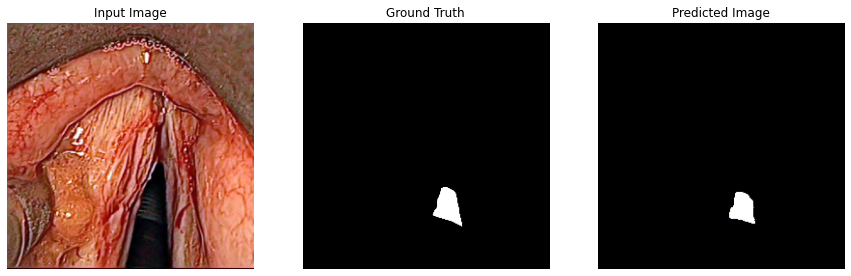

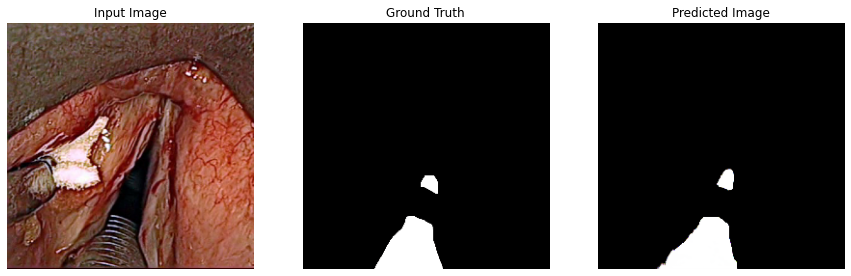

In [ ]:
# Run the trained model on a few examples from the test dataset
for example_input, example_target in test_dataset.take(2): 
    generate_images(gan.generator, example_input, example_target)

# Launch tensorboard

In [ ]:
%load_ext tensorboard
%tensorboard --logdir {log_dir}

# Load saved checkpoints

In [ ]:
!ls {CHECKPOINTS_DIR}

pix2pix_checkpoint.1300-47.data-00000-of-00001
pix2pix_checkpoint.1300-47.index
pix2pix_checkpoint.1325-48.data-00000-of-00001
pix2pix_checkpoint.1325-48.index
pix2pix_checkpoint.1700-63.data-00000-of-00001
pix2pix_checkpoint.1700-63.index
pix2pix_checkpoint.1800-67.data-00000-of-00001
pix2pix_checkpoint.1800-67.index
pix2pix_checkpoint.2000-75.data-00000-of-00001
pix2pix_checkpoint.2000-75.index
pix2pix_checkpoint.425-12.data-00000-of-00001
pix2pix_checkpoint.425-12.index


In [ ]:
if not os.path.isfile(CHECKPOINTS_DIR+"/checkpoint"):
  print(f"ATTENTION: Main 'checkpoint' file not found in {CHECKPOINTS_DIR} directory !!! \n"+
        "Maybe your training cannot be restarted and the model you are trying to load is unusable.")

ckpt = tf.train.Checkpoint(epoch=tf.Variable(1),
                          generator=gan.generator,
                          discriminator=gan.discriminator,
                          g_optimizer=gan.g_optimizer,
                          d_optimizer=gan.d_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, CHECKPOINTS_DIR, max_to_keep=None)

for i, checkpoint in enumerate(ckpt_manager.checkpoints, start=0):
    print (f'{i} - {checkpoint}')

In [ ]:
#confirm last checkpoint match
ckpt_manager.latest_checkpoint

In [ ]:
# restore specific checkpoint (change string name 
# with the disired checkpoint name as show above) 

# using chkpt filename
chckpnt_file = CHECKPOINTS_DIR + '/pix2pix_checkpoint.1700-63'

# using chkpt list index
# chckpnt_file = ckpt_manager.checkpoints[3]

# or restore the latest checkpoint
# chckpnt_file = ckpt_manager.latest_checkpoint


ckpt.restore(chckpnt_file)

# Continue restored training

Get epoch number from checkpoint filename

In [ ]:
def get_epoch_number_from_checkpoint_file_name(checkpoint_file_name=""):
  return checkpoint_file_name.split('.')[1].split('-')[0]  

Compile model with loaded checkpoint

In [ ]:
# resume model
# note that it has been created a **resume_model** object
# the model is initialized with the weights recover from the last checkpoint
# or a specifict checkpoint
# **fn** are simple functions that not depend on saved weitghts
resume_gan = GAN(discriminator=ckpt.discriminator, generator=ckpt.generator)
resume_gan.compile(
    d_optimizer=ckpt.d_optimizer,
    g_optimizer=ckpt.g_optimizer, 
    d_loss_fn=discriminator_loss,
    g_loss_fn=generator_loss
)

Train loaded form checkpoint model

In [ ]:
# comment below line to interrupt execution and not restore trainin process
# break
#
train_history_resume = resume_gan.fit(
    train_dataset, 
    epochs=EPOCHS, 
    callbacks=[
               GANMonitor(test_dataset),
               tensorboard_callback,
               checkpoint_callback, 
               metrics_monitor_callback
               ],
    batch_size=BATCH_SIZE,
    initial_epoch = int(get_epoch_number_from_checkpoint_file_name(chckpnt_file))
)

# Dice coeff and AUC

In [ ]:
def generate_images_dice_coef(model, test_input, tar):
    """
    model: Pix2Pix generator model (segmentator)
    test_imput: Real glotis image
    tar: training or real segmented mask
    """
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15, 15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # Getting the pixel values in the [0, 1] range to plot.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')

    plt.show()

    print(f"Dice coefficient: {dice_coef(tar, prediction)}")
    print(f"AUC: {auc(tar, prediction)}")

# Export model to H5 and tensorflow native format

In [ ]:
# use loaded checkpoint model
epoch_number = int(get_epoch_number_from_checkpoint_file_name(chckpnt_file))

# #Models dirs
PIX2PIX_MODEL_DIR = '/content/drive/MyDrive/dcgan_pix2pix/vocalfolds/pix2pix_model'
# # Models files
PIX2PIX_GENERATOR_MODEL_FILENAME = f"{PIX2PIX_MODEL_DIR}/generator/pix2pix_gen_{epoch_number}"
PIX2PIX_DISCRIMINATOR_MODEL_FILENAME = f"{PIX2PIX_MODEL_DIR}/discriminator/pix2pix_disc_{epoch_number}"

# # Keras standard format (.h5 extension)
# resume_gan.generator.save(PIX2PIX_GENERATOR_MODEL_FILENAME+'.h5')
# resume_gan.discriminator.save(PIX2PIX_DISCRIMINATOR_MODEL_FILENAME+'.h5')

# # Tensorflow native format (without extension)
# resume_gan.generator.save(PIX2PIX_GENERATOR_MODEL_FILENAME)
# resume_gan.discriminator.save(PIX2PIX_DISCRIMINATOR_MODEL_FILENAME)



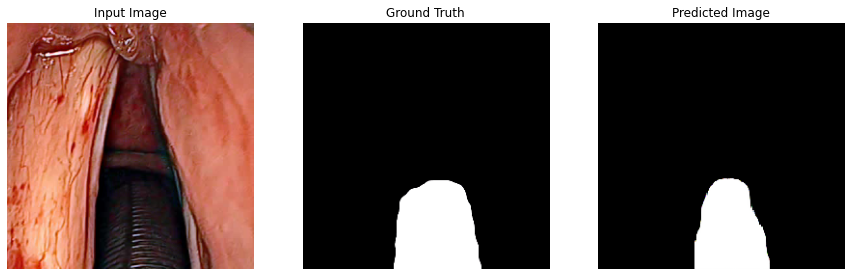

Dice coefficient: 0.8845099806785583
AUC: 0.9045003652572632


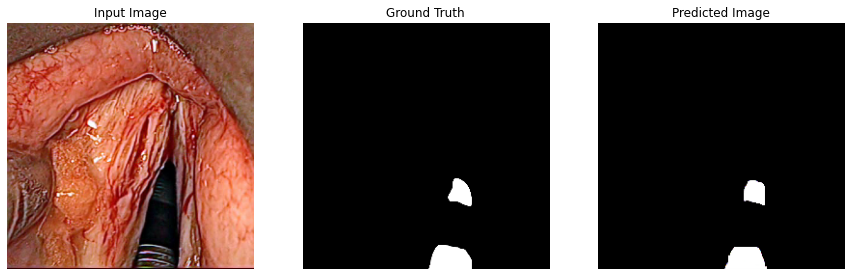

Dice coefficient: 0.9221977591514587
AUC: 0.941955029964447


In [ ]:
for inp, tar in test_dataset.take(2):
    # generate_images_dice_coef(generator, inp, tar)
    generate_images_dice_coef(resume_gan.generator, inp, tar)

# Generate to a folder Samples with loaded Model

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_test_metrics_history(dice_coef_hist, auc_hist, x_labels_list,
                                    dice_coef_label='test dice_coef', 
                                    auc_label='test auc', 
                                    filename='./plot_test_metrics.png',
                                    save_bests=5):
    
    # print(f"Epochs: {x_labels_list}")
    # print(f"Dice: {dice_coef_hist}")
    # print(f"AUC: {auc_hist}")

    x = np.arange(len(x_labels_list))  # the label locations
    width = 0.15  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, dice_coef_hist, width, label=dice_coef_label)
    rects2 = ax.bar(x + width/2, auc_hist, width, label=auc_label)

    # Add some text for labels, title and custom axis tick labels, etc.
    ax.set_ylabel('Metrics value')
    ax.set_xlabel('Epoch number')
    ax.set_title('Dice Coefficient and AUC for test dataset')
    ax.set_xticks(x)
    plt.grid(axis='y', alpha=.4)
    ax.set_yticks([0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1])
    ax.set_xticklabels(x_labels_list)
    ax.legend(loc='lower right')
    # ax.text(v + 3, i + .25, str(v), color='blue', fontweight='bold')
    fig.tight_layout()
    plt.savefig(filename)
    plt.show()
    plt.close()

In [ ]:
def find_best_model_checkpoints(checkpoint_manager=None, checkpoint=None,
                               dataset=None, plot_results=False, 
                               plot_filename="./plot_dice_auc.png", save_bests=3):
  """
  Finds best model checkpoint calculating Mean Dice coefficient and AUC metrics
  """
  if not (ckpt_manager and checkpoint and dataset):
    print("You must provide a dataset, checkpoint_manager and checkpoint objects")
  else:
    images_count = 0
    metrics_list = list()

    print(f"Dataset images count: {len(dataset)}")

    # for each chckpnt in checkpoint_manager.checkpoints:
    for i, chckpnt in enumerate(checkpoint_manager.checkpoints, start=0):
      # if i > 5:
      #   break
      mean_dice = total_dice = 0.0
      mean_auc = total_auc = 0.0
      """
      checkpoint.1060-53.data-00000-of-00001
      checkpoint.1060-53.index
      chckpnt: /content/drive/MyDrive/pix2pix/VocalFolds/checkpoints/checkpoint.320-16
      """
      # check if checkpoint is restorable
      if os.path.isfile(chckpnt+".data-00000-of-00001") and os.path.isfile(chckpnt+".index"):
        print(f"Checking metrics for {chckpnt} ...")
        # load checkpoint
        checkpoint.restore(chckpnt)
        # compile model
        resume_gan = GAN(discriminator=checkpoint.discriminator, generator=checkpoint.generator)
        resume_gan.compile(
            d_optimizer=checkpoint.d_optimizer,
            g_optimizer=checkpoint.g_optimizer,
            d_loss_fn=discriminator_loss,
            g_loss_fn=generator_loss
        )
        # iterate dataset and calc dice and auc
        total_dice = total_auc = 0
        images_count = 0
        # for each image in dataset
        for example_input, example_target in dataset.take(len(dataset)):
          images_count += 1
          prediction = resume_gan.generator(example_input, training=True)

          total_dice += dice_coef(example_target, prediction)
          total_auc += auc(example_target, prediction)

        mean_dice = total_dice / images_count
        mean_auc = total_auc / images_count

        chkpnt_epoch = get_epoch_number_from_checkpoint_file_name(chckpnt)
        # metrics dictionary
        metrics_dict = {'epoch': int(chkpnt_epoch),
                        'mean_dice': float(mean_dice),
                        'mean_auc': float(mean_auc),
                        'g_mean': (float(mean_dice) + float(mean_auc)) / 2
                        }
        metrics_list.append(metrics_dict)
    
    if plot_results:
      # sort metrics list by g_mean and get bests save_bests metrics with higher g_mean 
      bests_metrics = sorted(metrics_list, key = lambda i: (i['mean_auc'] + i['mean_dice']) / 2)[-save_bests:]
      # sort by epoch number
      bests_metrics = sorted(bests_metrics, key = lambda i: (i['epoch']))

      print(bests_metrics)

      mean_dice_coef_list = list()
      mean_auc_list = list()
      epochs_number_list = list()

      for metrics in bests_metrics:
        mean_dice_coef_list.append(metrics['mean_dice'])
        mean_auc_list.append(metrics['mean_auc'])
        epochs_number_list.append(metrics['epoch'])
      # plot results
      plot_test_metrics_history(dice_coef_hist=mean_dice_coef_list,
                                      auc_hist=mean_auc_list,
                                      x_labels_list=epochs_number_list,
                                      dice_coef_label='Dice Coefficient',
                                      auc_label='AUC',
                                      filename=plot_filename)
      print(f"\nResults has been saved to: {plot_filename}")

In [ ]:
find_best_model_checkpoints(checkpoint_manager=ckpt_manager, checkpoint=ckpt, 
                           dataset=test_dataset, plot_results=True, 
                           plot_filename=PLOTS_DIR + "/plot_test_dice_auc.png", 
                           save_bests=5)

In [ ]:
from tqdm.auto import tqdm
def calc_metrics_and_save_masks(dataset, take_test_images_count=0, 
                                generator_model=None, save_images=True, 
                                images_output_folder=DRIVE_TEST_GENERATED_IMAGES_DIR, 
                                images_prefix="test_dataset_gen_img"):
    """
    Run the loaded model, generate samples from test dataset
    and evaluate results with AUC and Dice Coefficient

    dataset: Dataset to generate and calc metrics against generated images by generator model
    take_test_images_count: Images count to take from provided dataset. 
                            If 0 then takes all images on dataset. Default 0
    generator_model: Pix2Pix generator model to segment dataset images. Default None
    save_images: Save or not segmented images. Default True, 
    images_output_folder: Output folder to save images. Defaults DRIVE_TEST_GENERATED_IMAGES_DIR value
    images_prefix: Prefix to geenrated images. Defaults "test_dataset_gen_img"
    """
    dataset_length = len(dataset)
    epoch_number = get_epoch_number_from_checkpoint_file_name(chckpnt_file)
    images_prefix = "chkpnt_" + epoch_number +"_"+ images_prefix

    if take_test_images_count > 0:
        # take_test_images_count = take_test_images_count
        if take_test_images_count > dataset_length:
            _take_count = dataset_length
        else:
            _take_count = take_test_images_count
    else:
        _take_count = dataset_length

    print(f'Test dateset image count: {dataset_length}')

    total_dice = mean_dice = total_auc = mean_auc = 0.0

    count = 0
    for example_input, example_target in tqdm(dataset.take(_take_count)):
        count += 1
        prediction = generator_model(example_input, training=True)
        horizontal = np.concatenate((example_input, example_target, prediction), axis = 2)
        img = horizontal[0] * 0.5 + 0.5 # denormalize image
        
        total_dice += dice_coef(example_target, prediction)
        total_auc += auc(example_target, prediction)

        # save_images(resume_gan.generator, example_input, example_target)
        if save_images:
            rnd = random.randint(0, 99999)
            
            keras.preprocessing.image.save_img(images_output_folder + '/'+images_prefix+'_%03d.jpg' % rnd, img)

    mean_dice = total_dice / count
    mean_auc = total_auc / count


    print(f"Done.\nMean Dice Coefficient: {mean_dice}\nMean AUC: {mean_auc}")

In [ ]:
# join both dataset 
# total_ds = train_dataset
# total_ds = total_ds.concatenate(test_dataset)

calc_metrics_and_save_masks(dataset=test_dataset, 
                            generator_model=resume_gan.generator, save_images=True, 
                            images_output_folder=DRIVE_TEST_GENERATED_IMAGES_DIR, 
                            images_prefix="test_dataset_gen_img")

Test dateset image count: 87


  0%|          | 0/87 [00:00<?, ?it/s]

Done.
Mean Dice Coefficient: 0.8513816595077515
Mean AUC: 0.9221046844433094
